In [1]:
# set seed for reproducibility
import torch
torch.manual_seed(42)

In [2]:
import os
import uproot
import numpy as np

def load_root_file(file_path, branches=None, print_branches=False):
    all_branches = {}
    with uproot.open(file_path) as file:
        tree = file["tree"]
        # Load all ROOT branches into array if not specified
        if branches is None:
            branches = tree.keys()
        # Option to print the branch names
        if print_branches:
            print("Branches:", tree.keys())
        # Each branch is added to the dictionary
        for branch in branches:
            try:
                all_branches[branch] = (tree[branch].array(library="np"))
            except uproot.KeyInFileError as e:
                print(f"KeyInFileError: {e}")
        # Number of events in file
        all_branches['event'] = tree.num_entries
    return all_branches

branches_list = [
    't5_innerRadius',
    't5_bridgeRadius',
    't5_outerRadius',
    't5_pt',
    't5_eta',
    't5_phi',
    't5_isFake',
    't5_t3_idx0',
    't5_t3_idx1',
    't5_t3_fakeScore1',
    't5_t3_promptScore1',
    't5_t3_displacedScore1',
    't5_t3_fakeScore2',
    't5_t3_promptScore2',
    't5_t3_displacedScore2',
    't5_pMatched',
    't5_sim_vxy',
    't5_sim_vz',
    't5_matched_simIdx'
]


# Hit-dependent branches
suffixes = ['r', 'z', 'eta', 'phi', 'layer']
branches_list += [f't5_t3_{i}_{suffix}' for i in [0, 2, 4] for suffix in suffixes]

file_path = "t5_dnn_500.root"
branches = load_root_file(file_path, branches_list)

In [3]:
z_max = np.max([np.max(event) for event in branches[f't5_t3_4_z']])
r_max = np.max([np.max(event) for event in branches[f't5_t3_4_r']])
eta_max = 2.5
phi_max = np.pi

print(f'Z max: {z_max}, R max: {r_max}, Eta max: {eta_max}')

def delta_phi(phi1, phi2):
    delta = phi1 - phi2
    # Adjust delta to be within the range [-pi, pi]
    if delta > np.pi:
        delta -= 2 * np.pi
    elif delta < -np.pi:
        delta += 2 * np.pi
    return delta

Z max: 267.2349853515625, R max: 110.10993957519531, Eta max: 2.5


In [4]:
features_list = []
eta_list = [] # Used for DNN cut values

for ev in range(branches['event']):
    # Determine the number of elements in this event
    num_elements = len(branches['t5_t3_idx0'][ev])

    for i in range(num_elements):
        features_iter = []
        eta_iter = []
        
        idx0 = branches['t5_t3_idx0'][ev][i]
        idx1 = branches['t5_t3_idx1'][ev][i]

        # hit-level quantities -------------------------------------------------
        eta1 = abs(branches['t5_t3_0_eta'][ev][idx0])
        eta2 = abs(branches['t5_t3_2_eta'][ev][idx0])
        eta3 = abs(branches['t5_t3_4_eta'][ev][idx0])
        eta4 = abs(branches['t5_t3_2_eta'][ev][idx1])
        eta5 = abs(branches['t5_t3_4_eta'][ev][idx1])

        phi1 = branches['t5_t3_0_phi'][ev][idx0]
        phi2 = branches['t5_t3_2_phi'][ev][idx0]
        phi3 = branches['t5_t3_4_phi'][ev][idx0]
        phi4 = branches['t5_t3_2_phi'][ev][idx1]
        phi5 = branches['t5_t3_4_phi'][ev][idx1]

        z1 = abs(branches['t5_t3_0_z'][ev][idx0])
        z2 = abs(branches['t5_t3_2_z'][ev][idx0])
        z3 = abs(branches['t5_t3_4_z'][ev][idx0])
        z4 = abs(branches['t5_t3_2_z'][ev][idx1])
        z5 = abs(branches['t5_t3_4_z'][ev][idx1])

        r1 = branches['t5_t3_0_r'][ev][idx0]
        r2 = branches['t5_t3_2_r'][ev][idx0]
        r3 = branches['t5_t3_4_r'][ev][idx0]
        r4 = branches['t5_t3_2_r'][ev][idx1]
        r5 = branches['t5_t3_4_r'][ev][idx1]

        inR  = branches['t5_innerRadius' ][ev][i]
        brR  = branches['t5_bridgeRadius'][ev][i]
        outR = branches['t5_outerRadius' ][ev][i]

        s1_fake   = branches['t5_t3_fakeScore1'     ][ev][i]
        s1_prompt = branches['t5_t3_promptScore1'   ][ev][i]
        s1_disp   = branches['t5_t3_displacedScore1'][ev][i]
        d_fake    = branches['t5_t3_fakeScore2'     ][ev][i] - s1_fake
        d_prompt  = branches['t5_t3_promptScore2'   ][ev][i] - s1_prompt
        d_disp    = branches['t5_t3_displacedScore2'][ev][i] - s1_disp

        # Construct the input feature vector using pairwise differences
        features_iter = [
            eta1 / eta_max,
            np.cos(phi1),
            np.sin(phi1),
            z1 / z_max,
            r1 / r_max,

            eta2 - eta1,
            delta_phi(phi2, phi1),
            (z2 - z1) / z_max,
            (r2 - r1) / r_max,

            eta3 - eta2,
            delta_phi(phi3, phi2),
            (z3 - z2) / z_max,
            (r3 - r2) / r_max,

            eta4 - eta3,
            delta_phi(phi4, phi3),
            (z4 - z3) / z_max,
            (r4 - r3) / r_max,

            eta5 - eta4,
            delta_phi(phi5, phi4),
            (z5 - z4) / z_max,
            (r5 - r4) / r_max,

            1.0 / inR,
            1.0 / brR,
            1.0 / outR,

            s1_fake, s1_prompt, s1_disp,
            d_fake,  d_prompt,  d_disp
        ]

        # Use the abs eta value of first hit to select cut thresholds
        eta_iter.extend([np.abs(branches['t5_t3_0_eta'][ev][idx0])])
        
        # Append the feature vector to the list
        features_list.append(features_iter)
        eta_list.append(eta_iter)

# Convert the list of features to a NumPy array
features = np.array(features_list).T
eta_list = np.array(eta_list).T

In [5]:
import torch
import numpy as np

# Stack features along a new axis to form a single array suitable for NN input
input_features_numpy = np.stack(features, axis=-1)

# Identify rows with NaN or Inf values
mask = ~np.isnan(input_features_numpy) & ~np.isinf(input_features_numpy)
row_mask = np.all(mask, axis=1)

# Apply row mask to features
filtered_input_features_numpy = input_features_numpy[row_mask]

# Also prepare arrays needed for labels
t5_pMatched_all = np.concatenate(branches['t5_pMatched'])
t5_sim_vxy_all  = np.concatenate(branches['t5_sim_vxy'])

t5_pMatched_filtered = t5_pMatched_all[row_mask]
t5_sim_vxy_filtered  = t5_sim_vxy_all[row_mask]

# Define "fake" like T3: use pMatched threshold (consistent with your T3 code)
t5_isFake_like = (t5_pMatched_filtered < 0.75)

# Convert inputs to tensors
input_features_tensor = torch.tensor(filtered_input_features_numpy, dtype=torch.float32)

def create_multiclass_labels(is_fake_bool, sim_vxy_array, displacement_threshold=0.1):
    """
    is_fake_bool: numpy bool array (True=fake)
    sim_vxy_array: numpy float array
    Returns torch.FloatTensor of shape [N, 3] one-hot (fake, prompt, displaced)
    """
    num_samples = len(is_fake_bool)
    labels = torch.zeros((num_samples, 3), dtype=torch.float32)

    fake_mask = torch.tensor(is_fake_bool, dtype=torch.bool)
    labels[fake_mask, 0] = 1.0

    real_mask = ~fake_mask
    sim_vxy_t = torch.tensor(sim_vxy_array, dtype=torch.float32)

    prompt_mask    = (sim_vxy_t <= displacement_threshold) & real_mask
    displaced_mask = (sim_vxy_t >  displacement_threshold) & real_mask

    labels[prompt_mask, 1]    = 1.0
    labels[displaced_mask, 2] = 1.0
    return labels

labels_tensor = create_multiclass_labels(t5_isFake_like, t5_sim_vxy_filtered, displacement_threshold=0.1)

In [6]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset, random_split

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 3-way network (like your T3)
class MultiClassNeuralNetwork(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.layer1 = nn.Linear(in_dim, 32)
        self.layer2 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 3)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return torch.softmax(x, dim=1)

# Weighted cross entropy (sample weights) like T3
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, outputs, targets, weights):
        eps = 1e-7
        log_probs = torch.log(outputs + eps)
        losses = -weights * torch.sum(targets * log_probs, dim=1)
        return losses.mean()

# Equalize class contributions via per-sample weights (like T3)
def calculate_class_weights(one_hot_labels: torch.Tensor):
    class_counts = torch.sum(one_hot_labels, dim=0)  # [3]
    total_samples = len(one_hot_labels)
    class_weights = total_samples / (3 * class_counts)  # inverse-frequency, normalized across 3 classes

    sample_weights = torch.zeros(len(one_hot_labels), dtype=torch.float32)
    for i in range(3):
        sample_weights[one_hot_labels[:, i] == 1] = class_weights[i]
    return sample_weights

print(f"Initial dataset size: {len(labels_tensor)}")

# We already filtered NaNs/Inf above; keep a nan guard like T3 (typically all False)
nan_mask = torch.isnan(input_features_tensor).any(dim=1) | torch.isnan(labels_tensor).any(dim=1)
filtered_inputs = input_features_tensor[~nan_mask]
filtered_labels = labels_tensor[~nan_mask]

downsample_classes = False
if downsample_classes:
    downsample_ratios = {0: 0.2, 1: 1.0, 2: 1.0}  # e.g., downsample fakes
    idx_list = []
    for cls in range(3):
        cls_mask = (filtered_labels[:, cls] == 1)
        cls_indices = torch.nonzero(cls_mask, as_tuple=True)[0]
        num_cls = cls_indices.numel()
        ratio = downsample_ratios.get(cls, 1.0)
        num_keep = max(1, int(num_cls * ratio)) if num_cls > 0 else 0
        if num_keep > 0:
            keep_idx = cls_indices[torch.randperm(num_cls)[:num_keep]]
            idx_list.append(keep_idx)
    if idx_list:
        keep = torch.cat(idx_list)
        filtered_inputs = filtered_inputs[keep]
        filtered_labels = filtered_labels[keep]

# Class-balanced sample weights (computed after optional downsampling)
filtered_weights = calculate_class_weights(filtered_labels)

# Dataset / loaders
dataset = TensorDataset(filtered_inputs, filtered_labels, filtered_weights)
train_size = int(0.8 * len(dataset))
test_size  = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True,  num_workers=10, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=1024, shuffle=False, num_workers=10, pin_memory=True)

# Initialize model/loss/opt
model = MultiClassNeuralNetwork(in_dim=filtered_inputs.shape[1]).to(device)
loss_function = WeightedCrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0025)

def evaluate_loss(loader):
    model.eval()
    total_loss = 0.0
    n_batches = 0
    with torch.no_grad():
        for x, y, w in loader:
            x, y, w = x.to(device), y.to(device), w.to(device)
            out = model(x)
            loss = loss_function(out, y, w)
            total_loss += loss.item()
            n_batches += 1
    return total_loss / max(1, n_batches)

num_epochs = 400
train_loss_log, test_loss_log = [], []

for epoch in range(num_epochs):
    model.train()
    epoch_loss, n_batches = 0.0, 0
    for x, y, w in train_loader:
        x, y, w = x.to(device), y.to(device), w.to(device)
        out = model(x)
        loss = loss_function(out, y, w)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        n_batches += 1

    train_loss = epoch_loss / max(1, n_batches)
    test_loss  = evaluate_loss(test_loader)
    train_loss_log.append(train_loss)
    test_loss_log.append(test_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Using device: cuda
Initial dataset size: 5204111
Epoch [1/400], Train Loss: 0.7831, Test Loss: 0.7656
Epoch [2/400], Train Loss: 0.7577, Test Loss: 0.7478
Epoch [3/400], Train Loss: 0.7268, Test Loss: 0.7053
Epoch [4/400], Train Loss: 0.6936, Test Loss: 0.6914
Epoch [5/400], Train Loss: 0.6816, Test Loss: 0.6734
Epoch [6/400], Train Loss: 0.6754, Test Loss: 0.6697
Epoch [7/400], Train Loss: 0.6707, Test Loss: 0.6672
Epoch [8/400], Train Loss: 0.6669, Test Loss: 0.6604
Epoch [9/400], Train Loss: 0.6640, Test Loss: 0.6585
Epoch [10/400], Train Loss: 0.6613, Test Loss: 0.6604
Epoch [11/400], Train Loss: 0.6589, Test Loss: 0.6528
Epoch [12/400], Train Loss: 0.6572, Test Loss: 0.6561
Epoch [13/400], Train Loss: 0.6559, Test Loss: 0.6558
Epoch [14/400], Train Loss: 0.6547, Test Loss: 0.6492
Epoch [15/400], Train Loss: 0.6533, Test Loss: 0.6525
Epoch [16/400], Train Loss: 0.6522, Test Loss: 0.6512
Epoch [17/400], Train Loss: 0.6514, Test Loss: 0.6530
Epoch [18/400], Train Loss: 0.6508, Test L

In [7]:
torch.save(model.state_dict(), "model.pth")

In [8]:
import numpy as np
import torch

# Use the full filtered tensors from above
X_all = input_features_tensor  # already filtered
Y_all = labels_tensor          # one-hot

def model_accuracy(features, labels, model):
    """Multi-class accuracy (argmax vs argmax)."""
    model.eval()
    with torch.no_grad():
        inputs = features.to(device)
        outputs = model(inputs)            # [N,3]
        pred = torch.argmax(outputs, dim=1)
        if labels.ndim > 1:                # one-hot -> class index
            labels = torch.argmax(labels, dim=1)
        acc = (pred.cpu() == labels.cpu()).float().mean().item()
    return acc

baseline_accuracy = model_accuracy(X_all, Y_all, model)
print(f"Baseline accuracy: {baseline_accuracy:.4f}")

feature_importances = np.zeros(X_all.shape[1], dtype=np.float64)

for i in range(X_all.shape[1]):
    X_perm = X_all.clone()
    X_perm[:, i] = X_perm[torch.randperm(X_perm.size(0)), i]
    acc_perm = model_accuracy(X_perm, Y_all, model)
    feature_importances[i] = baseline_accuracy - acc_perm

# Rank features
order = np.argsort(feature_importances)[::-1]
print("\nFeature importances:")
for idx in order:
    print(f"Feature {idx} importance: {feature_importances[idx]:.4f}")

Baseline accuracy: 0.7845

Feature importances:
Feature 10 importance: 0.3925
Feature 6 importance: 0.3880
Feature 22 importance: 0.3861
Feature 18 importance: 0.3361
Feature 12 importance: 0.2780
Feature 8 importance: 0.2528
Feature 21 importance: 0.2503
Feature 25 importance: 0.2078
Feature 24 importance: 0.1624
Feature 13 importance: 0.1484
Feature 26 importance: 0.1216
Feature 28 importance: 0.1163
Feature 0 importance: 0.1144
Feature 20 importance: 0.0961
Feature 16 importance: 0.0923
Feature 27 importance: 0.0903
Feature 3 importance: 0.0893
Feature 29 importance: 0.0876
Feature 9 importance: 0.0657
Feature 15 importance: 0.0481
Feature 17 importance: 0.0427
Feature 23 importance: 0.0374
Feature 5 importance: 0.0328
Feature 19 importance: 0.0324
Feature 4 importance: 0.0233
Feature 7 importance: 0.0215
Feature 11 importance: 0.0161
Feature 14 importance: 0.0037
Feature 1 importance: 0.0003
Feature 2 importance: 0.0000


In [9]:
def print_formatted_weights_biases(weights, biases, layer_name):
    # Print biases
    print(f"HOST_DEVICE_CONSTANT float bias_{layer_name}[{len(biases)}] = {{")
    print(", ".join(f"{b:.7f}f" for b in biases) + " };")
    print()

    # Print weights
    print(f"HOST_DEVICE_CONSTANT float wgtT_{layer_name}[{len(weights[0])}][{len(weights)}] = {{")
    for row in weights.T:
        formatted_row = ", ".join(f"{w:.7f}f" for w in row)
        print(f"{{ {formatted_row} }},")
    print("};")
    print()

def print_model_weights_biases(model):
    # Make sure the model is in evaluation mode
    model.eval()

    # Iterate through all named modules in the model
    for name, module in model.named_modules():
        # Check if the module is a linear layer
        if isinstance(module, nn.Linear):
            # Get weights and biases
            weights = module.weight.data.cpu().numpy()
            biases = module.bias.data.cpu().numpy()

            # Print formatted weights and biases
            print_formatted_weights_biases(weights, biases, name.replace('.', '_'))

print_model_weights_biases(model)


HOST_DEVICE_CONSTANT float bias_layer1[32] = {
-0.1678386f, 0.0062221f, 0.4177751f, 0.2357259f, -0.9462857f, -0.3409990f, -0.1872155f, 0.1828108f, -0.4457844f, 0.3936582f, -0.1411160f, -0.2311078f, 1.2161102f, -0.2947264f, 0.1894379f, 0.5512197f, 0.0449618f, -0.8239868f, -0.3477916f, 0.4225373f, -0.4130838f, -0.4287525f, -1.2734071f, 0.1026133f, -0.9753121f, 0.4862165f, -0.2817556f, 0.2095301f, -1.4500864f, 0.5061237f, 0.4188634f, 0.7349724f };

HOST_DEVICE_CONSTANT float wgtT_layer1[30][32] = {
{ 0.0783816f, -1.1879421f, 1.2561915f, -0.9396452f, -0.7376533f, 0.7421755f, 0.0745148f, -1.4108288f, 0.1165716f, -0.0588236f, -0.1923094f, 0.7504381f, -0.3192962f, 1.2013903f, 1.1387057f, -1.3546553f, -2.0270951f, -0.2932444f, -0.1410570f, -0.0805406f, -0.0974531f, 2.5211759f, 1.7349756f, -0.0467459f, 2.7711246f, 0.9582202f, 0.4102616f, 1.4269719f, 2.9677136f, -1.1691868f, -0.1483863f, -0.7312705f },
{ 0.0042622f, 0.0120303f, 0.0036669f, -0.0202874f, -0.0015261f, -0.0026689f, 0.0216810f, 0.002

In [10]:
with torch.no_grad():
    model.eval()
    probs = model(input_features_tensor.to(device)).cpu().numpy()  # cols: [fake, prompt, displaced]

# Prepare filtered arrays aligned with 'probs' via the same row_mask you used above
eta_abs_f   = eta_list[0][row_mask]
pt_f        = np.concatenate(branches['t5_pt'])[row_mask]
pMatched_f  = np.concatenate(branches['t5_pMatched'])[row_mask]
isFake_f    = np.concatenate(branches['t5_isFake'])[row_mask]
sim_vxy_f   = np.concatenate(branches['t5_sim_vxy'])[row_mask]

# Track-type masks (match T3 logic)
matched_mask         = (pMatched_f > 0.95)
fake_mask            = (pMatched_f < 0.75)  # or (isFake_f == 1)
true_prompt_mask     = matched_mask & (sim_vxy_f <= 0.1)
true_displaced_mask  = matched_mask & (sim_vxy_f >  0.1)

# Convenience views for class probabilities
prompt_probs    = probs[:, 1]
displaced_probs = probs[:, 2]
fake_probs      = probs[:, 0]  # used for fake-rejection calculation

[Prompt] eta 0.00-0.25: 213666 fakes, 150558 true
[Prompt] eta 0.25-0.50: 193035 fakes, 158097 true
[Prompt] eta 0.50-0.75: 180960 fakes, 224453 true
[Prompt] eta 0.75-1.00: 91958 fakes, 153975 true
[Prompt] eta 1.00-1.25: 164274 fakes, 195335 true
[Prompt] eta 1.25-1.50: 115708 fakes, 164882 true
[Prompt] eta 1.50-1.75: 71365 fakes, 234017 true
[Prompt] eta 1.75-2.00: 88959 fakes, 299739 true
[Prompt] eta 2.00-2.25: 48099 fakes, 252187 true
[Prompt] eta 2.25-2.50: 18743 fakes, 119420 true


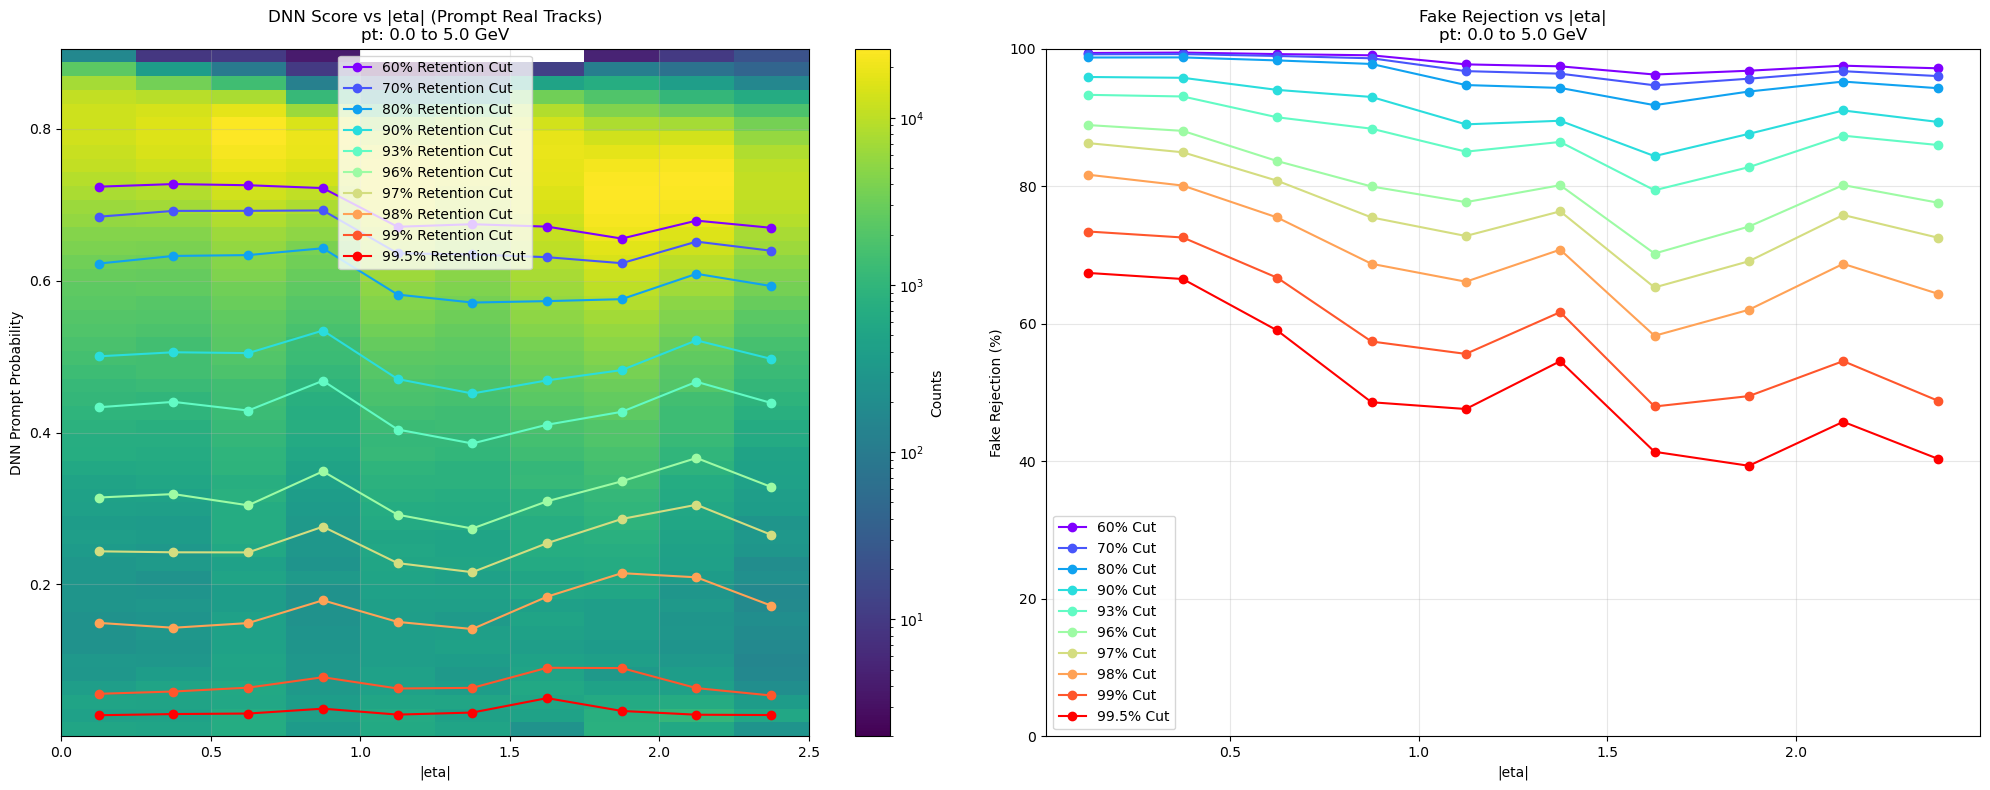


Prompt tracks, pt: 0.0 to 5.0 GeV
Number of true prompt tracks: 1952663
Number of fake tracks in pt bin: 1186767

60% Retention Cut Values: {0.7239, 0.7273, 0.7258, 0.7220, 0.6710, 0.6744, 0.6713, 0.6555, 0.6792, 0.6697} Mean: 0.6920
60% Cut Fake Rejections: {99.4, 99.4, 99.2, 99.0, 97.7, 97.4, 96.2, 96.8, 97.5, 97.2} Mean: 98.0%

70% Retention Cut Values: {0.6843, 0.6920, 0.6921, 0.6926, 0.6361, 0.6346, 0.6310, 0.6231, 0.6515, 0.6395} Mean: 0.6577
70% Cut Fake Rejections: {99.2, 99.2, 98.9, 98.6, 96.7, 96.4, 94.7, 95.6, 96.7, 96.0} Mean: 97.2%

80% Retention Cut Values: {0.6226, 0.6326, 0.6338, 0.6427, 0.5817, 0.5712, 0.5731, 0.5757, 0.6091, 0.5930} Mean: 0.6036
80% Cut Fake Rejections: {98.7, 98.7, 98.3, 97.8, 94.7, 94.3, 91.8, 93.8, 95.2, 94.3} Mean: 95.8%

90% Retention Cut Values: {0.5004, 0.5057, 0.5047, 0.5344, 0.4705, 0.4515, 0.4687, 0.4823, 0.5215, 0.4970} Mean: 0.4937
90% Cut Fake Rejections: {95.9, 95.8, 94.0, 93.0, 89.0, 89.5, 84.4, 87.6, 91.0, 89.4} Mean: 91.0%

93% Reten

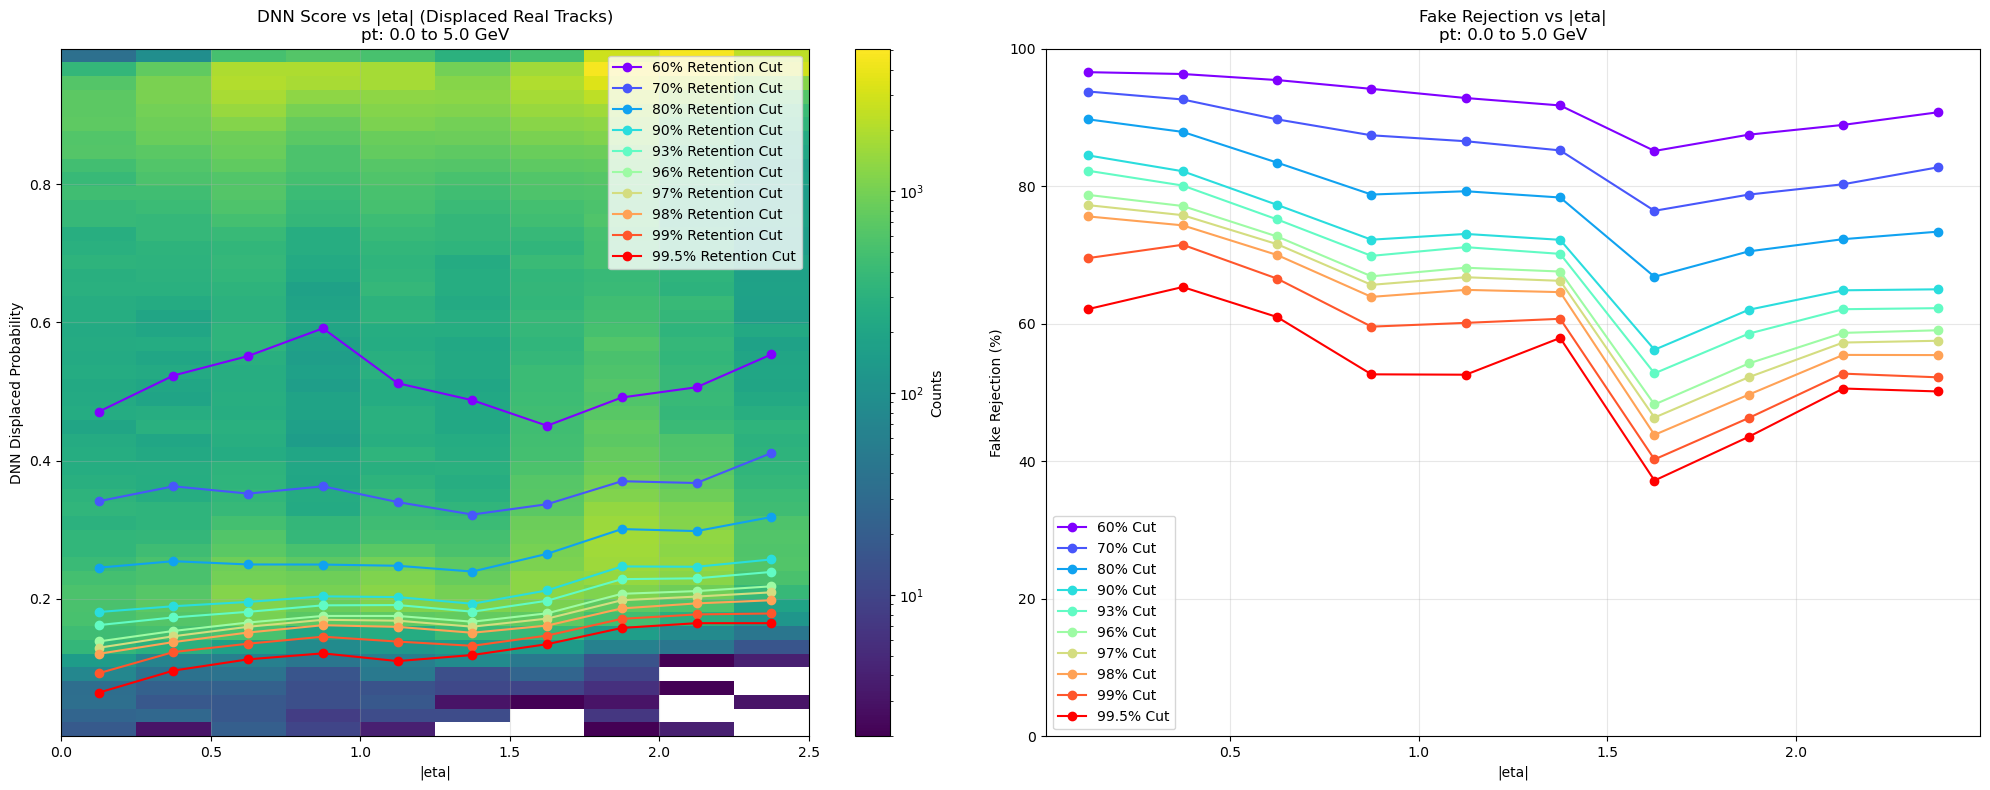


Displaced tracks, pt: 0.0 to 5.0 GeV
Number of true displaced tracks: 263859
Number of fake tracks in pt bin: 1186767

60% Retention Cut Values: {0.4708, 0.5232, 0.5514, 0.5915, 0.5120, 0.4874, 0.4504, 0.4913, 0.5061, 0.5537} Mean: 0.5138
60% Cut Fake Rejections: {96.6, 96.3, 95.4, 94.2, 92.8, 91.8, 85.1, 87.5, 88.9, 90.7} Mean: 91.9%

70% Retention Cut Values: {0.3412, 0.3628, 0.3522, 0.3628, 0.3399, 0.3219, 0.3368, 0.3701, 0.3675, 0.4109} Mean: 0.3566
70% Cut Fake Rejections: {93.8, 92.6, 89.7, 87.4, 86.5, 85.2, 76.4, 78.8, 80.3, 82.7} Mean: 85.4%

80% Retention Cut Values: {0.2450, 0.2543, 0.2496, 0.2495, 0.2477, 0.2393, 0.2650, 0.3008, 0.2979, 0.3183} Mean: 0.2668
80% Cut Fake Rejections: {89.7, 87.9, 83.4, 78.8, 79.3, 78.4, 66.8, 70.5, 72.3, 73.4} Mean: 78.1%

90% Retention Cut Values: {0.1808, 0.1891, 0.1954, 0.2034, 0.2024, 0.1927, 0.2121, 0.2468, 0.2463, 0.2569} Mean: 0.2126
90% Cut Fake Rejections: {84.5, 82.2, 77.3, 72.2, 73.1, 72.2, 56.2, 62.0, 64.9, 65.0} Mean: 71.0%

93% 

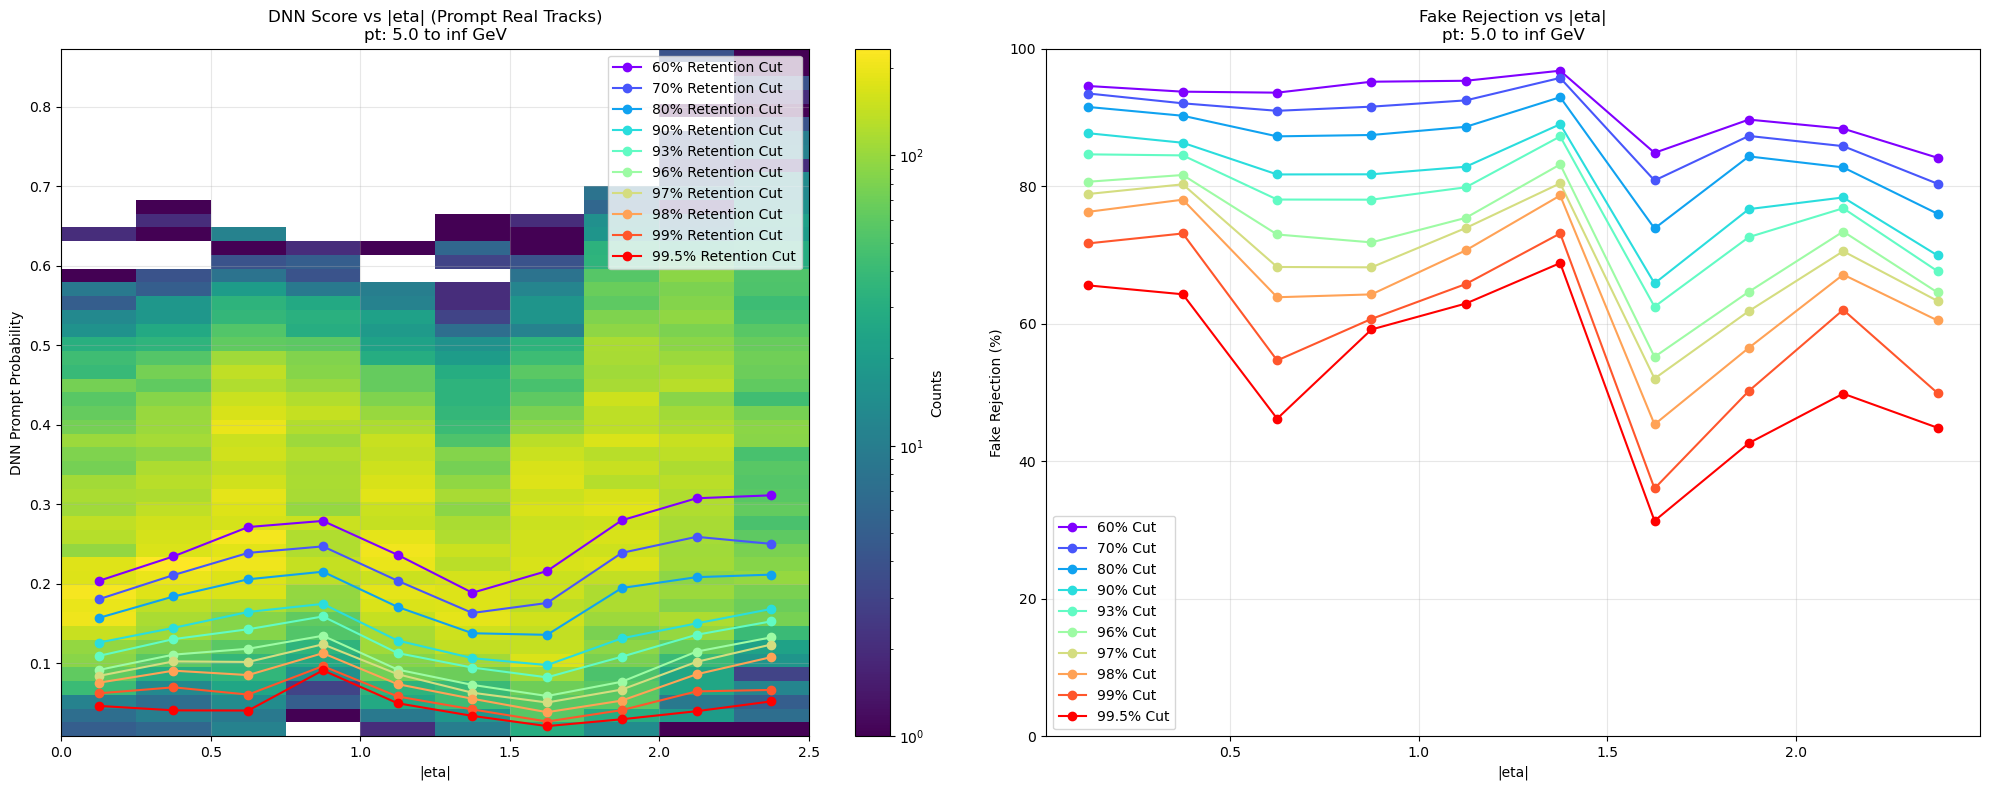


Prompt tracks, pt: 5.0 to inf GeV
Number of true prompt tracks: 30348
Number of fake tracks in pt bin: 58045

60% Retention Cut Values: {0.2033, 0.2342, 0.2711, 0.2788, 0.2361, 0.1884, 0.2158, 0.2796, 0.3073, 0.3110} Mean: 0.2525
60% Cut Fake Rejections: {94.6, 93.8, 93.6, 95.2, 95.3, 96.8, 84.9, 89.7, 88.4, 84.1} Mean: 91.6%

70% Retention Cut Values: {0.1802, 0.2106, 0.2386, 0.2467, 0.2035, 0.1630, 0.1755, 0.2386, 0.2588, 0.2499} Mean: 0.2165
70% Cut Fake Rejections: {93.5, 92.1, 91.0, 91.6, 92.5, 95.8, 80.8, 87.3, 85.8, 80.4} Mean: 89.1%

80% Retention Cut Values: {0.1567, 0.1837, 0.2053, 0.2149, 0.1705, 0.1375, 0.1355, 0.1943, 0.2080, 0.2112} Mean: 0.1818
80% Cut Fake Rejections: {91.5, 90.3, 87.3, 87.5, 88.6, 93.0, 73.9, 84.3, 82.7, 76.0} Mean: 85.5%

90% Retention Cut Values: {0.1257, 0.1442, 0.1642, 0.1744, 0.1283, 0.1061, 0.0974, 0.1310, 0.1498, 0.1680} Mean: 0.1389
90% Cut Fake Rejections: {87.7, 86.3, 81.7, 81.7, 82.8, 89.0, 65.9, 76.7, 78.4, 69.9} Mean: 80.0%

93% Retention

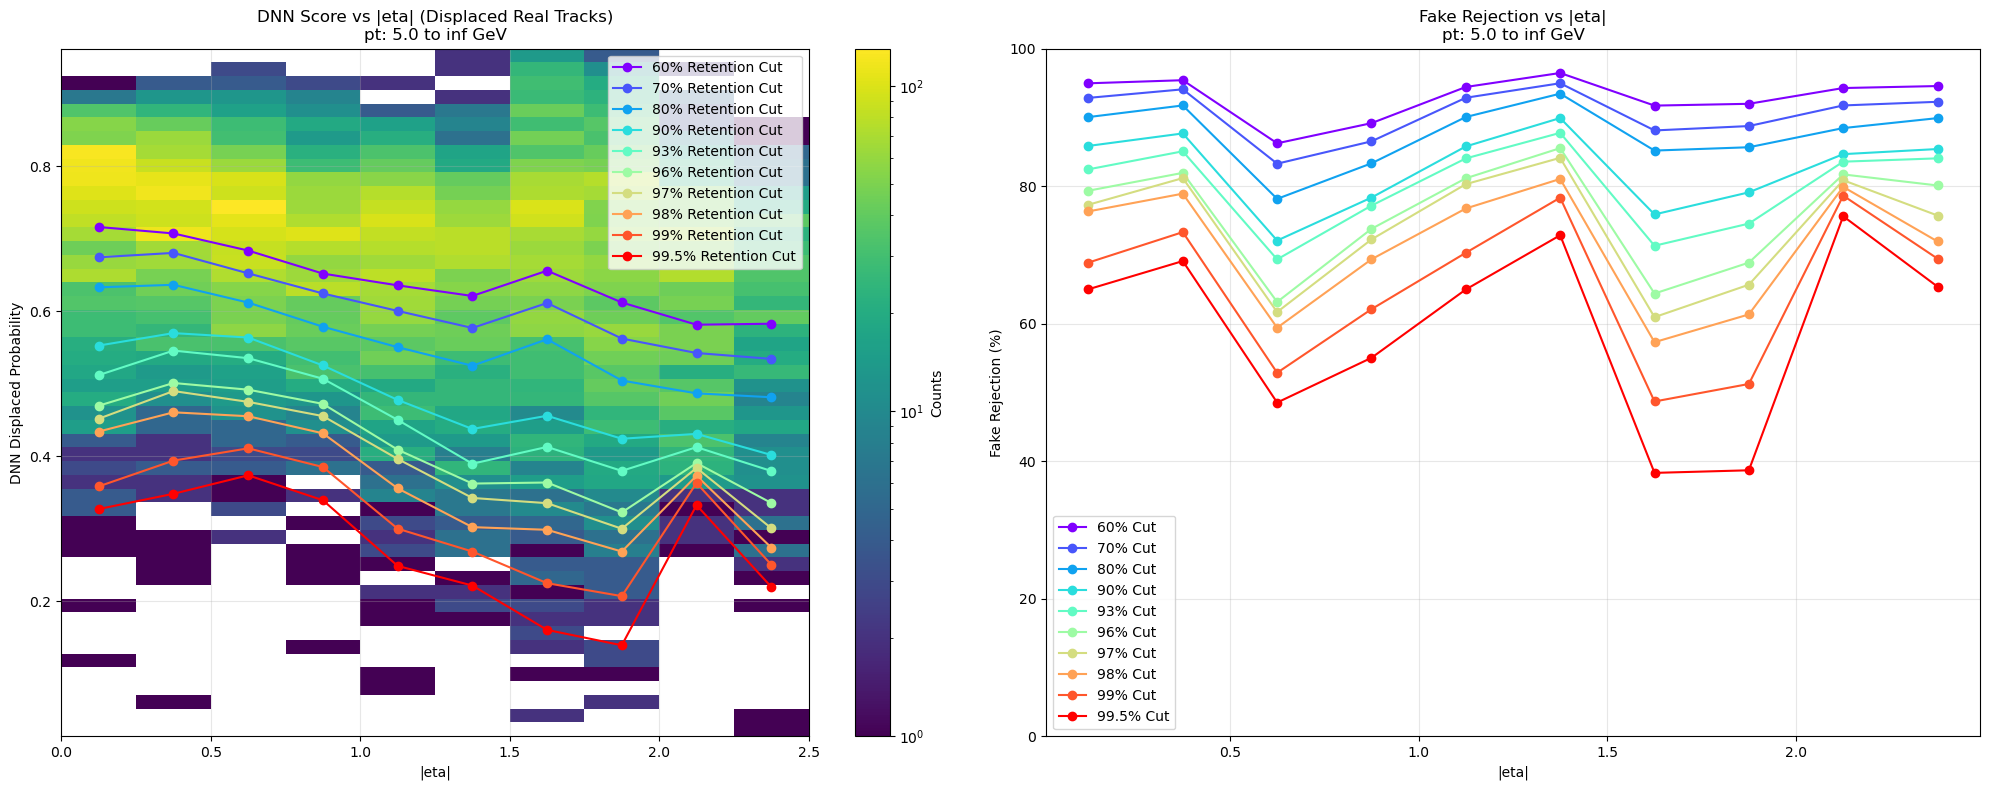


Displaced tracks, pt: 5.0 to inf GeV
Number of true displaced tracks: 11375
Number of fake tracks in pt bin: 58045

60% Retention Cut Values: {0.7160, 0.7071, 0.6835, 0.6518, 0.6356, 0.6210, 0.6558, 0.6120, 0.5814, 0.5827} Mean: 0.6447
60% Cut Fake Rejections: {95.0, 95.4, 86.2, 89.2, 94.4, 96.5, 91.7, 92.0, 94.3, 94.6} Mean: 92.9%

70% Retention Cut Values: {0.6743, 0.6803, 0.6521, 0.6244, 0.6004, 0.5769, 0.6113, 0.5623, 0.5424, 0.5343} Mean: 0.6059
70% Cut Fake Rejections: {92.9, 94.1, 83.3, 86.5, 92.9, 95.0, 88.1, 88.8, 91.8, 92.3} Mean: 90.6%

80% Retention Cut Values: {0.6329, 0.6364, 0.6118, 0.5786, 0.5504, 0.5248, 0.5613, 0.5044, 0.4868, 0.4814} Mean: 0.5569
80% Cut Fake Rejections: {90.1, 91.7, 78.2, 83.3, 90.1, 93.5, 85.2, 85.7, 88.5, 89.9} Mean: 87.6%

90% Retention Cut Values: {0.5526, 0.5698, 0.5637, 0.5252, 0.4777, 0.4377, 0.4559, 0.4242, 0.4309, 0.4019} Mean: 0.4839
90% Cut Fake Rejections: {85.9, 87.7, 72.1, 78.4, 85.8, 89.9, 75.9, 79.1, 84.7, 85.4} Mean: 82.5%

93% Ret

In [12]:
# %%
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_for_pt_bin_t5(pt_min, pt_max, percentiles, eta_bin_edges,
                       eta_abs, pt, probs, true_prompt_mask, true_displaced_mask, fake_mask):
    """
    Reproduces the T3-style threshold plots/printouts for T5:
      - For each of {Prompt, Displaced}, in a given pT bin:
          * 2D hist of class prob vs |eta| for true tracks of that type
          * Overlaid percentile-retention cuts vs |eta|
          * A companion plot: fake rejection (%) vs |eta| at those cuts
      - Prints per-eta-bin stats and cut means, like your T3 cell
    """
    in_pt = (pt > pt_min) & (pt <= pt_max)

    for track_type, true_mask_global, col_idx, title_suffix in [
        ("Prompt",    true_prompt_mask,    1, "Prompt Real Tracks"),
        ("Displaced", true_displaced_mask, 2, "Displaced Real Tracks"),
    ]:
        # Restrict to pT bin
        abs_eta   = eta_abs[in_pt]
        probs_bin = probs[in_pt, col_idx]
        true_mask = true_mask_global[in_pt]
        fake_bin  = fake_mask[in_pt]

        # Containers for per-eta-bin values
        cut_values      = {p: [] for p in percentiles}
        fake_rejections = {p: [] for p in percentiles}

        # Figure with two panels (like your T3 code): density + fake rejection
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # 2D histogram for true tracks of this type
        h = ax1.hist2d(abs_eta[true_mask],
                       probs_bin[true_mask],
                       bins=[eta_bin_edges, 50],
                       norm=LogNorm())
        plt.colorbar(h[3], ax=ax1, label='Counts')

        # Per-|eta| bin loops
        bin_centers = []
        for i in range(len(eta_bin_edges) - 1):
            eta_min, eta_max = eta_bin_edges[i], eta_bin_edges[i+1]
            eta_center = 0.5 * (eta_min + eta_max)
            bin_centers.append(eta_center)

            in_eta = (abs_eta >= eta_min) & (abs_eta < eta_max)

            # True of this type in the bin
            true_bin = in_eta & true_mask
            # Fakes in the bin
            fake_in_bin = in_eta & fake_bin

            # Optional: quick readout as in your T3 code
            print(f"[{track_type}] eta {eta_min:.2f}-{eta_max:.2f}: "
                  f"{np.sum(fake_in_bin)} fakes, {np.sum(true_bin)} true")

            if np.any(true_bin):
                for p in percentiles:
                    # Retain p% of true => cut at (100 - p) percentile of that class probability
                    cut = np.percentile(probs_bin[true_bin], 100 - p)
                    cut_values[p].append(cut)

                    # Fake rejection at that cut (prob < cut => rejected for this class)
                    if np.any(fake_in_bin):
                        rej = 100.0 * np.mean(probs_bin[fake_in_bin] < cut)
                        fake_rejections[p].append(rej)
                    else:
                        fake_rejections[p].append(np.nan)
            else:
                for p in percentiles:
                    cut_values[p].append(np.nan)
                    fake_rejections[p].append(np.nan)

        # Overlay retention cuts on the density plot
        bin_centers = np.asarray(bin_centers)
        colors = plt.cm.rainbow(np.linspace(0, 1, len(percentiles)))
        for p, c in zip(percentiles, colors):
            vals = np.asarray(cut_values[p])
            m = ~np.isnan(vals)
            if np.any(m):
                ax1.plot(bin_centers[m], vals[m], '-', color=c, marker='o',
                         label=f'{p}% Retention Cut')

        ax1.set_xlabel("|eta|")
        ax1.set_ylabel(f"DNN {track_type} Probability")
        ax1.set_title(f"DNN Score vs |eta| ({title_suffix})\npt: {pt_min:.1f} to {pt_max:.1f} GeV")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Fake rejection plot
        for p, c in zip(percentiles, colors):
            rej = np.asarray(fake_rejections[p])
            m = ~np.isnan(rej)
            if np.any(m):
                ax2.plot(bin_centers[m], rej[m], '-', color=c, marker='o',
                         label=f'{p}% Cut')

        ax2.set_xlabel("|eta|")
        ax2.set_ylabel("Fake Rejection (%)")
        ax2.set_title(f"Fake Rejection vs |eta|\npt: {pt_min:.1f} to {pt_max:.1f} GeV")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_ylim(0, 100)

        plt.tight_layout()
        plt.show()

        # Summary printouts (match the T3 style)
        n_true_type = int(np.sum(true_mask))
        n_fakes_bin = int(np.sum(fake_bin))
        print(f"\n{track_type} tracks, pt: {pt_min:.1f} to {pt_max:.1f} GeV")
        print(f"Number of true {track_type.lower()} tracks: {n_true_type}")
        print(f"Number of fake tracks in pt bin: {n_fakes_bin}")
        for p in percentiles:
            vals = np.asarray(cut_values[p])
            rejs = np.asarray(fake_rejections[p])
            print(f"\n{p}% Retention Cut Values:",
                  '{' + ', '.join(f"{x:.4f}" if not np.isnan(x) else 'nan' for x in vals) + '}',
                  f"Mean: {np.nanmean(vals):.4f}")
            print(f"{p}% Cut Fake Rejections:",
                  '{' + ', '.join(f"{x:.1f}" if not np.isnan(x) else 'nan' for x in rejs) + '}',
                  f"Mean: {np.nanmean(rejs):.1f}%")

def analyze_pt_bins_t5(pt_bins, percentiles, eta_bin_edges,
                       eta_abs, pt, probs, true_prompt_mask, true_displaced_mask, fake_mask):
    for i in range(len(pt_bins) - 1):
        plot_for_pt_bin_t5(pt_bins[i], pt_bins[i + 1], percentiles, eta_bin_edges,
                           eta_abs, pt, probs, true_prompt_mask, true_displaced_mask, fake_mask)

# Example call (same defaults as your T3 cell)
percentiles   = [60, 70, 80, 90, 93, 96, 97, 98, 99, 99.5]
pt_bins       = [0, 5, np.inf]
eta_bin_edges = np.arange(0, 2.75, 0.25)

analyze_pt_bins_t5(
    pt_bins=pt_bins,
    percentiles=percentiles,
    eta_bin_edges=eta_bin_edges,
    eta_abs=eta_abs_f,
    pt=pt_f,
    probs=probs,  # [N,3]
    true_prompt_mask=true_prompt_mask,
    true_displaced_mask=true_displaced_mask,
    fake_mask=fake_mask
)

In [15]:
import numpy as np

targets = {
    "low":  {"pt_lo": 0.0, "pt_hi": 5.0,    "prompt": 0.98, "displaced": 0.95},
    "high": {"pt_lo": 5.0, "pt_hi": np.inf, "prompt": 0.985, "displaced": 0.95},
}

# --- binning and search controls ---
eta_bin_edges = np.arange(0.0, 2.75, 0.25)   # change if you want different eta granularity
grid_points   = 121                          # per-axis quantile grid for tP/tD (reduce if slow)
tol_prompt    = 0.002                        # absolute tolerance on prompt eff per bin
tol_displaced = 0.002                        # absolute tolerance on displaced eff per bin

# convenience views
pP = probs[:, 1]          # prompt prob
pD = probs[:, 2]          # displaced prob

# safety: denominators won't be zero
_eps = 1

def optimize_eta_pt_bin(in_bin_mask, tgt_prompt, tgt_displ):
    """Find (tP, tD) in this bin to hit both targets (within tol) and maximize fake rejection."""
    if not np.any(in_bin_mask):
        return None

    pP_b = pP[in_bin_mask]
    pD_b = pD[in_bin_mask]

    trueP_b = true_prompt_mask[in_bin_mask]
    trueD_b = true_displaced_mask[in_bin_mask]
    fake_b  = fake_mask[in_bin_mask]

    n_trueP = max(_eps, int(trueP_b.sum()))
    n_trueD = max(_eps, int(trueD_b.sum()))
    n_fake  = max(_eps, int(fake_b.sum()))
    n_tot   = int(in_bin_mask.sum())

    # Build candidate thresholds from quantiles in-bin, focused on signal where possible
    qs = np.linspace(0.0, 1.0, grid_points)
    cand_tP = np.quantile(pP_b[trueP_b] if np.any(trueP_b) else pP_b, qs)
    cand_tD = np.quantile(pD_b[trueD_b] if np.any(trueD_b) else pD_b, qs)

    # Deduplicate and ensure bounds
    cand_tP = np.unique(np.clip(cand_tP, 0.0, 1.0))
    cand_tD = np.unique(np.clip(cand_tD, 0.0, 1.0))

    best = None
    best_key = None  # (penalty, -fake_rej, -min(ach_prompt, ach_displ))

    # Precompute boolean arrays for speed
    # (vectorizing fully across the 2D grid is memory-heavy; nested loop is fine here)
    for tp in cand_tP:
        passP = (pP_b >= tp)
        for td in cand_tD:
            sel = passP | (pD_b >= td)

            ach_prompt = (sel & trueP_b).sum() / n_trueP if n_trueP > 0 else 0.0
            ach_displ  = (sel & trueD_b).sum() / n_trueD if n_trueD > 0 else 0.0

            # penalties outside tolerance
            ep = max(0.0, abs(ach_prompt - tgt_prompt) - tol_prompt)
            ed = max(0.0, abs(ach_displ  - tgt_displ ) - tol_displaced)
            penalty = ep + ed

            fake_rej = 100.0 * (1.0 - (sel & fake_b).sum() / n_fake)

            key = (penalty, -fake_rej, -min(ach_prompt, ach_displ))
            if (best is None) or (key < best_key):
                best_key = key
                best = dict(
                    tP=float(tp), tD=float(td),
                    ach_prompt=float(ach_prompt),
                    ach_displ=float(ach_displ),
                    fake_rej=float(fake_rej),
                    n_tot=n_tot, n_trueP=int(trueP_b.sum()),
                    n_trueD=int(trueD_b.sum()), n_fake=int(fake_b.sum())
                )
    return best

In [17]:
results = []  # keep if you still want to inspect per-bin metrics

# Store thresholds per pT bin as arrays aligned with eta bins (length = len(eta_bin_edges)-1)
thresholds_by_pt = {
    "low":  {"tP": np.full(len(eta_bin_edges)-1, np.nan, dtype=np.float32),
             "tD": np.full(len(eta_bin_edges)-1, np.nan, dtype=np.float32)},
    "high": {"tP": np.full(len(eta_bin_edges)-1, np.nan, dtype=np.float32),
             "tD": np.full(len(eta_bin_edges)-1, np.nan, dtype=np.float32)},
}

for pt_key, cfg in targets.items():
    p_lo, p_hi = cfg["pt_lo"], cfg["pt_hi"]
    tgtP, tgtD = cfg["prompt"], cfg["displaced"]

    in_pt = (pt_f > p_lo) & (pt_f <= p_hi)
    if not np.any(in_pt):
        continue

    for i_eta in range(len(eta_bin_edges)-1):
        e_lo, e_hi = eta_bin_edges[i_eta], eta_bin_edges[i_eta+1]
        in_eta = (eta_abs_f >= e_lo) & (eta_abs_f < e_hi)
        sel_bin = in_pt & in_eta
        res = optimize_eta_pt_bin(sel_bin, tgtP, tgtD)

        if res is not None:
            thresholds_by_pt[pt_key]["tP"][i_eta] = res["tP"]
            thresholds_by_pt[pt_key]["tD"][i_eta] = res["tD"]

# ---------- C++ table printout ----------
def _fmt_row(vals):
    vals = [0.0 if not np.isfinite(v) else float(v) for v in vals]
    return ", ".join(f"{v:.6f}f" for v in vals)

low_tP  = thresholds_by_pt["low"]["tP"]
high_tP = thresholds_by_pt["high"]["tP"]
low_tD  = thresholds_by_pt["low"]["tD"]
high_tD = thresholds_by_pt["high"]["tD"]

print("      HOST_DEVICE_CONSTANT float kWp_prompt[kPtBins][kEtaBins] = {")
print(f"          {{ {_fmt_row(low_tP)} }},")
print(f"          {{ {_fmt_row(high_tP)} }}")
print("      };")
print("      HOST_DEVICE_CONSTANT float kWp_displaced[kPtBins][kEtaBins] = {")
print(f"          {{ {_fmt_row(low_tD)} }},")
print(f"          {{ {_fmt_row(high_tD)} }}")
print("      };")

      HOST_DEVICE_CONSTANT float kWp_prompt[kPtBins][kEtaBins] = {
          { 0.398084f, 0.403121f, 0.354281f, 0.358435f, 0.367765f, 0.349150f, 0.378903f, 0.373203f, 0.406608f, 0.374461f },
          { 0.097341f, 0.106300f, 0.077975f, 0.103842f, 0.124790f, 0.052589f, 0.054577f, 0.112889f, 0.179196f, 0.200328f }
      };
      HOST_DEVICE_CONSTANT float kWp_displaced[kPtBins][kEtaBins] = {
          { 0.421372f, 0.466420f, 0.611434f, 0.646523f, 0.543573f, 0.552745f, 0.577597f, 0.630934f, 0.620449f, 0.665398f },
          { 0.674274f, 0.768983f, 0.888747f, 0.847046f, 0.566714f, 0.946426f, 0.912854f, 0.522756f, 0.538444f, 0.473106f }
      };
